# Word2Vec

In [40]:
# packageのimport
import os 
import math 
from typing import Any, Union, Callable, Type, TypeVar
from tqdm.std import trange,tqdm
import numpy as np 
import numpy.typing as npt
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

# pytorch関連のimport
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

## 単語のベクトル表現

自然言語処理において，単語をそのまま機械学習モデルに扱わせることはできません．そのため，それぞれの単語に対応するベクトル表現を利用することになります．このベクトル表現方法はいろいろとあり，離散表現と分散表現という大別ができます．これらについて見ていきましょう．

### 離散表現と分散表現

単語をベクトルとして表現する方法として古くから使われているのがone-hot表現（1-of-K表現とも呼ばれます）です．これはある要素のみが1でそれ以外が0であるような表現のことであり，単語に対応したベクトルのある要素のみが1でそれ以外が0であるようなベクトルを用いることで，単語をベクトル表現します．

> ![](https://jiho-ml.com/content/images/2020/04/figure1-4.png)  
one-hot表現のイメージ  
出典: [위클리 NLP Week 2 - 단어를 가방에 때려 넣으면 문장이 된다](https://jiho-ml.com/weekly-nlp-2/)

one-hotベクトルはシンプルなアイディアで理解しやすいですが，語彙の数だけベクトルの次元数が必要になることに注意が必要です．また，「オートバイ」と「バイク」のようなほぼほぼ似たような意味の単語同士の類似度をcosine類似度で計算しようとしても，それぞれが別の次元が立っているだけのベクトルなので内積0となってしまい，意味的な類似度を測ることには適さないことがわかります．

ここではこのone-hot表現を離散表現の例として紹介しました．

また，文書中に登場した単語のone-hotベクトルを足し合わせることで，文書をベクトル表現するBag-of-Words（BoW）という表現方法もあります．
> ![](https://jiho-ml.com/content/images/2020/04/figure2-3.png)  
BoWのイメージ  
出典: [위클리 NLP Week 2 - 단어를 가방에 때려 넣으면 문장이 된다](https://jiho-ml.com/weekly-nlp-2/)




この場合はただ足し合わせるだけなので，文書中に同じ単語が何回か登場したら，1以上の整数がベクトル内に現れることもあります．
> ![](https://www.programmersought.com/images/947/0acb9279d17a1631bcfb154583cca443.JPEG)  
BoWのイメージ2   
出典: [Comparison of word bag model BoW and word set model SoW  |ProgrammerSought](https://jiho-ml.com/weekly-nlp-2/)




onehotやbowの様な表現方法は非常に簡便で分かりやすい反面，語彙数分だけの次元数が常に必要になるなどの嬉しくない特徴を持ちます．

### 様々な分散表現

one-hot表現に対して，分散表現とは単語を語彙数に比べて低次元の実数値ベクトルで表す表現です．気持ちとしては，one-hotで表現された単語をより低次元空間の座標として表現し，one-hot→embedding→onehotの様に可逆圧縮しているイメージです．そのため多くの場合任意の比較的小さい次元数（50, 100, 200, 300次元など）が用いられています．これの利点としては，
- 語彙数に左右されずにベクトルの次元数を決定できるため計算量を抑えられる
- 同じような意味の単語に同じようなベクトル表現を当てがうことができるのならば，cosine類似度のような簡単な計算で意味の類似度（のようなもの）を評価することができる

などが考えられます．現代の自然言語処理においても，このアプローチが取られることが多いです．

> ![](./figs/w2v/encoding.png)  
離散表現と分散表現  
出典: [なぜ自然言語処理にとって単語の分散表現は重要なのか？](https://qiita.com/Hironsan/items/a58636f946dd51f670b0) 

この分散表現の作り方には色々な方法があります．例えばBoWで表現された文章データをNMF（Non-Negative Matrix Factorization, 非負値行列因子分解）{cite}`Lee1999-ge,Lee2000-ld`やLSA（Latent Semantic Analysis, 潜在的意味解析）{cite}`Deerwester1990-tn`のような手法で行列分解することで作成することもできます．ただし作成できるベクトルが持つ意味（作成されたベクトルがどのような使い方に適したものなのか）は手法により様々です．今回は，ニューラルネットワークを用いて単語の分散表現が作れるword2vec{cite}`Mikolov2013-ok,Mikolov2013-yn,Mikolov2013-zb`と呼ばれる手法群の中でも，CBOWについて紹介します．

## Continuous Bag-of-Words

### CBOWと分布仮説

:::{margin}
> word2vec はある単語から周囲の単語を予測するタスクを解くことで，各単語の低次元（数百次元）の分散表現を獲得する手法です．この手法は，分布仮説「単語の意味は周囲の単語との関係性から規定される」に基づいて次元削減で低次のベクトル表現を獲得することある条件下において同等であると証明されています．分布仮説において，例えば，「ラーメン」と「うどん」はそれぞれ，「食べる」や「昼飯」や「麺」などの同じ単語と共起しやすいため，この二つの単語は近いと考えられます．  
　自然言語における __分布仮説__ は，ネットワーク分析における「ある人を知りたければその友人を見よ」や「論文の内容はその引用関係から推定できる」という考え方と類似しています．  
> 引用: [Vol.31.No.4(2016/7)ネットワークの表現学習 -- 人工知能学会](https://www.ai-gakkai.or.jp/resource/my-bookmark/my-bookmark_vol31-no4/#:~:text=%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E5%88%86%E5%B8%83%E4%BB%AE%E8%AA%AC%E3%81%AF%EF%BC%8C%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E5%88%86%E6%9E%90%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E3%80%8C%E3%81%82%E3%82%8B%E4%BA%BA%E3%82%92%E7%9F%A5%E3%82%8A%E3%81%9F%E3%81%91%E3%82%8C%E3%81%B0%E3%81%9D%E3%81%AE%E5%8F%8B%E4%BA%BA%E3%82%92%E8%A6%8B%E3%82%88%E3%80%8D%E3%82%84%E3%80%8C%E8%AB%96%E6%96%87%E3%81%AE%E5%86%85%E5%AE%B9%E3%81%AF%E3%81%9D%E3%81%AE%E5%BC%95%E7%94%A8%E9%96%A2%E4%BF%82%E3%81%8B%E3%82%89%E6%8E%A8%E5%AE%9A%E3%81%A7%E3%81%8D%E3%82%8B%E3%80%8D%E3%81%A8%E3%81%84%E3%81%86%E8%80%83%E3%81%88%E6%96%B9%E3%81%A8%E9%A1%9E%E4%BC%BC%E3%81%97%E3%81%A6%E3%81%84%E3%81%BE%E3%81%99%EF%BC%8E%E3%81%93%E3%81%AE%E3%82%88%E3%81%86%E3%81%AB%EF%BC%8C%E5%88%86%E5%B8%83%E4%BB%AE%E8%AA%AC%E3%81%AB%E5%9F%BA%E3%81%A5%E3%81%84%E3%81%9F%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86%E3%81%A8%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E5%88%86%E6%9E%90%E3%81%AF%EF%BC%8C%E5%91%A8%E5%9B%B2%E3%81%AE%E9%96%A2%E4%BF%82%E6%80%A7%E3%81%8B%E3%82%89%E8%A6%81%E7%B4%A0%E3%81%AE%E6%80%A7%E8%B3%AA%E3%82%92%E6%8E%A8%E5%AE%9A%E3%81%99%E3%82%8B%E3%81%A8%E3%81%84%E3%81%86%E6%84%8F%E5%91%B3%E3%81%A7%E8%BF%91%E3%81%84%E3%81%A8%E3%81%84%E3%81%88%E3%81%BE%E3%81%99%EF%BC%8E2014%20%E5%B9%B4%E3%81%AB%E7%99%BA%E8%A1%A8%E3%81%95%E3%82%8C%E3%81%9FDeepWalk%20%E3%81%AF%EF%BC%8C%E3%81%93%E3%81%AE%E8%80%83%E3%81%88%E6%96%B9%E3%82%92%E3%82%82%E3%81%A8%E3%81%ABword2vec,%E3%82%92%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E6%A7%8B%E9%80%A0%E3%81%AE%E8%A1%A8%E7%8F%BE%E5%AD%A6%E7%BF%92%E3%81%AB%E5%BF%9C%E7%94%A8%E3%81%97%E3%81%9F%E6%89%8B%E6%B3%95%E3%81%A7%E3%81%99%EF%BC%8EDeepWalk%20%E3%81%A7%E3%81%AF%EF%BC%8C%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF%E3%81%AE%E3%83%AA%E3%83%B3%E3%82%AF%E4%B8%8A%E3%82%92%E3%83%A9%E3%83%B3%E3%83%80%E3%83%A0%E3%82%A6%E3%82%A9%E3%83%BC%E3%82%AF%E3%81%99%E3%82%8B%E3%81%93%E3%81%A8%E3%81%AB%E3%82%88%E3%81%A3%E3%81%A6%E8%BE%BF%E3%82%8C%E3%82%8B%E3%83%8E%E3%83%BC%E3%83%89%E3%81%AE%E5%88%97%E3%82%92%E2%80%9D%E6%96%87%E8%84%88%E2%80%9D%E3%81%A8%E3%81%BF%E3%81%AA%E3%81%97%EF%BC%8C%E3%81%9D%E3%81%AE%E6%96%87%E8%84%88%E3%82%92word2vec%20%E3%81%AB%E3%82%A4%E3%83%B3%E3%83%97%E3%83%83%E3%83%88%E3%81%97%E3%81%A6%E3%83%8E%E3%83%BC%E3%83%89%E3%81%AE%E5%88%86%E6%95%A3%E8%A1%A8%E7%8F%BE%E3%82%92%E8%A8%88%E7%AE%97%E3%81%97%E3%81%BE%E3%81%99%EF%BC%8E)

:::

例えば以下の文章があったときに，__XXX__ や __YYY__ に相当する単語がなんなのかがわかるでしょうか？  
![](./figs/w2v/zettaiwakarurei.png)

（この例ではもちろんXXXは __ガンダム__ ですし，YYYは __ノリス・パッカード大佐__ ですね．） 

私たちはある単語を聞きそびれたり，何かの固有名詞が分からなくても，周辺の言葉から大体類推して言葉の意味を把握することができます．

このような「単語の意味は、周囲の単語によって形成される」という仮説を自然言語処理では __分布仮説__ と呼びます．

この文脈において，対象の単語の周辺の単語のことをコンテキストと呼びます．

![](./figs/w2v/context.png)  
説明したい単語「goodbye」と，その周辺にあってこの単語の意味を推測するのに使えそうな単語達（コンテキスト）の関係．  
出典: [ゼロから作るDeep Learning 2 自然言語処理編](https://www.oreilly.co.jp/books/9784873118369/)

この分布仮説をもとに，ニューラルネットワークを使って単語の意味をある程度表現できるようなベクトル表現を獲得できる手法がこれから紹介するCBOWです．

### CBOWのアーキテクチャ

CBoWでは，周辺の単語を入力にして目的の単語を予測するネットワークを構築します．

![](./figs/w2v/context2.png)  
コンテキストを使った単語の予測．  
出典: [ゼロから作るDeep Learning 2 自然言語処理編](https://www.oreilly.co.jp/books/9784873118369/)

CBOWは単純なMLPを利用して，語彙数$V$，埋め込み次元数$N$の場合に，全ての語彙それぞれに対応する単語埋め込みベクトルの束である$\mathbf{W}_{V, N}$を作成します．（ノーテーションは正しく定義しておけばなんでもいいのですが，私は埋め込み次元数を$L$と置くことが多いです．）



> ![Illustration of the word2vec models: (a) CBOW, (b) skip-gram [16, 33]. ](https://www.researchgate.net/profile/Elena-Tutubalina/publication/318507923/figure/fig2/AS:613947946319904@1523388005889/Illustration-of-the-word2vec-models-a-CBOW-b-skip-gram-16-33.png)  
word2vecのアーキテクチャ．左側がCBoW，また右側はSkip-Gram．   
出典: [Demographic Prediction Based on User Reviews about Medications](https://www.scielo.org.mx/pdf/cys/v21n2/1405-5546-cys-21-02-00227.pdf)

### 実装

::::{admonition} Embeddingsから任意の単語に対応したものを取り出す
:class: dropdown

CBoWの実装を考える時に気にしなければいけないのが，どうやって任意の単語の埋め込みベクトルを取り出すのかと言う問題です．例えば語彙数が5, 埋め込み次元数が3の単語埋め込み行列があるとします．
```py
W = torch.tensor([[ 0.4019, -0.1891, -0.3723],
        [-0.3303,  0.2106, -0.0976],
        [-0.2294, -0.3021,  0.3005],
        [ 0.2210,  0.4406,  0.1265],
        [-0.3187, -0.2617,  0.0953]],dtype=torch.float32)
```
ここから0番目の語彙の単語埋め込みベクトルを取り出すには，onehotベクトルとのdot積を取ればOKです．
```py
x = torch.tensor([1,0,0,0,0],dtype=torch.float32)
x @ W
```
出力: tensor([ 0.4019, -0.1891, -0.3723])

また同様に，これはミニバッチごとにまとめて取ることも可能です．

```py
x = torch.tensor([[1,0,0,0,0],[0,0,0,0,1]],dtype=torch.float32)
x @ W
```
出力:  
tensor([[ 0.4019, -0.1891, -0.3723],  
        [-0.3187, -0.2617,  0.0953]])  

contextsに含まれる単語の単語埋め込みベクトルを取る際にも上のテクニックは使えますが，このベクトルを取り出した後に要素ごとに平均をとる必要があります．これはつまり要素ごとに足した後に単語数で割っているだけなので，contextsをbowにして，これを入力にすれば「要素ごとに足した後のベクトル」が得られます．後はcontextsの要素数で各要素を割ればOKです．

::::

まずは，forwardメソッドの入力値が「コンテクストのBoW表現」である場合の実装を考えます．一層目の全結合層の結合重みをそれぞれの語彙に対応する単語埋め込みベクトルとして利用しましょう．

一つ目のnn.Linearはこのモデルで扱いたい語彙（異なり語，ユニークな単語）の数$V$（コード中では `vocab_size`）の数だけベクトルを持っており，入力された語彙に対応したベクトルを取り出して返します．この語彙に対応したベクトルを __単語埋め込みベクトル__ と呼びます．また，単語埋め込みベクトルの次元数$N$を __埋め込み次元数__ などと呼び，コード中では `embedding_dim`という変数で扱います．  
**ある単語は，同じ文書中に存在する「その単語の周辺に出現する単語」によって類推することができる**というのが自然言語処理の分布仮説でした．これに則り，周辺単語を入力として，予測したい単語の出現確率を出力するMLPを作ります．

```python
class CBoW(nn.Module):
    def __init__(self, vocab_size:int, embedding_dim:int) -> None:
        super().__init__()
        self.embeddingbag = nn.Linear(vocab_size, embedding_dim, bias=False)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs:Any)->Any:
        h = self.embeddingbag(inputs) / inputs.sum(1)[:,None]
        return self.linear(h)
```

この実装のCBoWクラスはMLPとほぼ同じなので非常にわかりやすいですが，contextsをBoW表現に直す必要があります．データが少ない場合は問題になりませんが，データ量が増えた時には大変です．

PyTorchでは，このような実装をしなくとも単語のid列を入力に，onehotやbowを介さずに埋め込みベクトルを返してくれる`nn.Embedding`クラスと`nn.Embeddingbag`クラスがあります．これを使ってより賢い実装を以下に示します．

```{hint}
単語idを一つ一つ単語埋め込みベクトルに変換したいなら`nn.Embedding`を使います．文書（単語idのシーケンス）に対する単純な埋め込みベクトルが欲しいならば`nn.Embeddingbag`を使います．
```

In [32]:
class CBoW(nn.Module):
    def __init__(self, vocab_size:int, embedding_dim:int) -> None:
        super().__init__()
        self.embeddingbag = nn.EmbeddingBag(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs:Any)->Any:
        h = self.embeddingbag(inputs) / inputs.size(-1)
        return self.linear(h)

クラスの実装上で明確に異なるのはMLPの最初のLinear層の代わりに，Embeddingbagレイヤーと名付けられた層が追加されていることです．これによりforwardメソッドへの入力をいちいちonehotやbowにしなくとも，単語idのシーケンスを渡すだけで，埋め込みベクトルを返してくれます．

<!-- この実装は図で示したものとは少し異なります，このアーキテクチャのお気持ちとしては「単語を埋め込み表現に直した後に，それらの要素ごとの和を取る」作業を nn.Embeddingとnn.Linearの一つ目で行なう感じです．最終的に欲しいword embedding（単語埋め込み）はnn.Embeddingが持っているので，それ以降に関しては多少自由が効きます．また，-->
最終層は「ターゲットの単語が出現する確率」なので，Softmax関数を用います（ここでもSoftmaxを利用することにします）．ただし，word2vecが発表された当初はGPUで計算するのではなく，CPUで計算できるような工夫として，Softmaxを近似した別の関数を利用していました．これにはHierarchical Softmax（階層的ソフトマックス）やNegative Sampling（不例サンプリング）が用いられます．是非調べてみてください．

### 損失関数

$x$の出現確率$p(x)$とモデルの予測した$x$の出現確率$q(x)$の交差エントロピーは以下のように求まります．

$$
H(p, q) = -\sum_{x} p(x) \log(q(x))
$$ (crossentropy)

今回の場合，予測したい単語が$y$であり，これは単語idになっています．これを語彙数$V$のonehotベクトルにする関数を$\operatorname{onehot}(y)$としましょう．  
コード中，CBoWのforwardメソッドの出力（予測する値）はself.linear(h)であり，下に示す訓練ループの中ではlogitsとされてますが，これは全結合層の出力でしかありません．本来はこれをSoftmaxに通した値が出力値であり，これが予測したい単語の出現確率です．よってここでのクロスエントロピーは

$$
H(y,\operatorname{logits}) = -\operatorname{onehot}(y) \cdot \log(\operatorname{softmax}(\operatorname{logits}))
$$ (cbow_crossentropy)

で求められます．ただし，minibatchごとに訓練する場合は，データ一つ一つに対して計算した後に平均をとる必要があります．

## 実験

### データのダウンロード

wikipediaを使いやすい形で公開してくれている[text8](http://mattmahoney.net/dc/textdata.html)の日本語版，[ja.text8](https://github.com/Hironsan/ja.text8)を使ってw2vを学習してみましょう．

In [8]:
import os 
if "ja.text8" not in os.listdir("./data/"):
    !wget -P ./data https://s3-ap-northeast-1.amazonaws.com/dev.tech-sketch.jp/chakki/public/ja.text8.zip
    !unzip ./data/ja.text8.zip

### データの準備

In [33]:
with open("./data/ja.text8") as f:
    text8 = f.read()

print(text8[:200])

ちょん 掛け （ ちょん がけ 、 丁 斧 掛け ・ 手斧 掛け と も 表記 ） と は 、 相撲 の 決まり 手 の ひとつ で ある 。 自分 の 右 （ 左 ） 足 の 踵 を 相手 の 右 （ 左 ） 足 の 踵 に 掛け 、 後方 に 捻っ て 倒す 技 。 手斧 （ ちょう な ） を かける 仕草 に 似 て いる こと から 、 ちょう な が 訛っ て ちょん 掛け と なっ 


ja.text8では（英文のように）単語ごとにスペースを入れてくれているので，簡単にこれ以降の自然言語処理に進めます．このような処理を __分かち書き__ と呼びます．

本当はtext8の全てのデータを使いたいのですが，学習に時間がかかりすぎるので1/10の量を使うことにします．

In [34]:
LIMIT = math.floor(len(text8)*0.1)
print(f"{LIMIT}/ {len(text8)}")

text8 = text8[:LIMIT]

4650779/ 46507793


読み込んだテキストから，以下の条件で単語をフィルタリングします．
1. 日本語のみで構成された単語だけを取り出します．
2. 5個以上の文書に出現している単語のみを取り出し

ここまでやった後に，語彙の辞書を作ります．
1. id2word（id→単語）
2. word2id (単語→id)

In [35]:
import re
def build_simply_dictionary(texts):
    token_set = set(token for text in texts for token in text.split())
    word2id = {token:id for id, token in enumerate(token_set)}  
    return word2id

def my_analyzer(text):
    #text = code_regex.sub('', text)
    tokens = text.split()
    tokens = filter(lambda token: re.search(r'[ぁ-ん]+|[ァ-ヴー]+|[一-龠]+', token), tokens)
    return tokens 

def build_dictionary(texts, min_df=1):
    from sklearn.feature_extraction.text import CountVectorizer
    countvectorizer = CountVectorizer(min_df=min_df, analyzer=my_analyzer)

    X = countvectorizer.fit_transform(texts)
    id2word = {id:w for id,w in enumerate(countvectorizer.get_feature_names_out())}
    word2id = {w:id for id,w in id2word.items()}
    return id2word, word2id, X

texts = text8.split("。")
id2word, word2id,X = build_dictionary(texts,5)
V = len(id2word)
D = len(texts)
print(f"文書数: {D}, 語彙数: {V}")

文書数: 57498, 語彙数: 17143


ここでは，予測したい単語とコンテキストを合わせたものをウィンドウと呼びます．このウィンドウサイズを5として，予測したい単語の前後2単語をまとめた5単語を取り出し，contextsとtargetを作成します．

In [36]:
def build_contexts_and_target(preprocessed_texts, window_size=5):
    contexts = []
    target = []
    a = window_size//2
    for text in preprocessed_texts:
        for i in range(a, len(text)-a):
            target.append(text[i])
            tmp = text[i-a:i]
            tmp += text[i+1:i+1+a]
            contexts.append(tmp)
    return np.array(contexts), np.array(target)

In [37]:
WINDOW_SIZE = 11

preprocessed_texts = [[word2id[w] for w in text.split() if w in word2id] for text in texts]
preprocessed_texts = [text for text in preprocessed_texts if len(text) > WINDOW_SIZE]
contexts, target = build_contexts_and_target(preprocessed_texts, WINDOW_SIZE)
print("前処理後の文書数:", len(preprocessed_texts))
print(f"contextsの数: {len(contexts)}")

前処理後の文書数: 44599
contextsの数: 750947


ミニバッチを作成する関数を用意します．

In [38]:
def get_batch(contexts, target, batch_size=32, shuffle=True):
    D = target.size
    index = np.arange(D)
    
    if shuffle:
        np.random.shuffle(index)

    n_batches = D // batch_size
    for minibatch_indexes in np.array_split(index, n_batches):
        a = torch.tensor(contexts[minibatch_indexes])
        b = torch.tensor(target[minibatch_indexes])
        yield a,b

### 訓練ループの作成

通常のMLPと同様の学習ループを作成します．w2vの学習は時間がかかるので，プログレスバーを表示するようにしておきます．ここではepochごとに更新するバーとミニバッチごとに更新するバーを用意します．（ここで使うコーパスサイズだと，CPUで10~20分程度かかります）


学習が終わり次第，損失関数の増減を折れ線グラフにして確認できるようにもしておきましょう．

loading pretrained weights...
training CBoW from scrach...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [11:24<00:00, 68.49s/it]


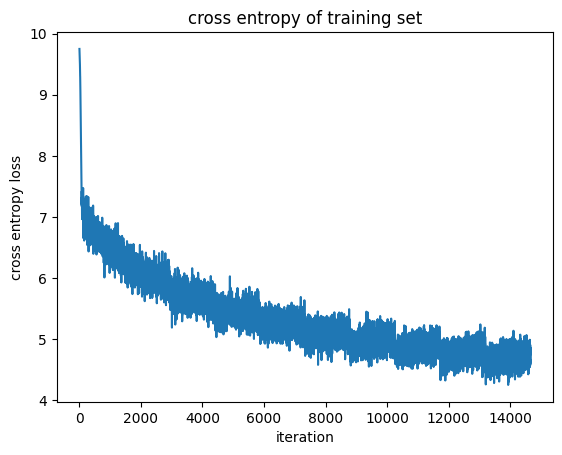

In [42]:
max_epochs = 10
lr = 0.01
batch_size = 512
L = 50
n_batches = len(target) // batch_size
DEVICE="cpu"
if torch.cuda.is_available():
    DEVICE ="cuda:0"

cbow = CBoW(V, L)
criterion = nn.CrossEntropyLoss()
save_fname = f"{cbow.__class__.__name__}_ep{max_epochs}_lr{lr}_b{batch_size}_emb{L}.pth"

"""
# 学習済みの重みがある場合
print("loading pretrained weights...")
cbow.load_state_dict(torch.load(f"./models/{save_fname}"))
cbow.eval()
"""

# 学習済みの重みがない場合
print("training CBoW from scrach...")
cbow.train()
cbow = cbow.to(DEVICE)
optimizer = optim.Adam(cbow.parameters(), lr=lr)
monitoring_loss = []

for epoch in trange(max_epochs):
    with tqdm(total=n_batches) as tbar:
        for batch in get_batch(contexts, target, batch_size):
            x,y = batch
            x,y = x.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()
            logits = cbow(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            
            monitoring_loss.append(float(loss))
            tbar.update(1)
cbow.eval()
cbow = cbow.cpu()
torch.save(cbow.state_dict(), f"./models/{save_fname}")

plt.title("cross entropy of training set")
plt.xlabel("iteration")
plt.ylabel("cross entropy loss")
plt.plot(monitoring_loss)

### 類似単語検索

CBoWでは第一層目の結合重みが単語埋め込みベクトルとして利用できます．例えばこれは，以下のようなコードで取り出すことが可能です．
```python
word_embeddings = list(cbow.embeddingbag.parameters())[0].data.detach().cpu().numpy()
```

ここから更にクエリとして与えられた単語に対応する単語埋め込みベクトルを取り出して，自分以外の全ての埋め込みベクトルとの類似度を計算することで，類似単語検索が実装できます．
ここでは類似として __コサイン類似度__ {eq}`cosine_similarity`を使います．

$$
\cos (\mathbf{x}, \mathbf{y})=\frac{\langle\mathbf{x}, \mathbf{y}\rangle}{\|\mathbf{x}\|\|\mathbf{y}\|} =\frac{\sum_{k=1}^N x_k y_k}{\sqrt{\sum_{k=1}^N x_k^2} \sqrt{\sum_{k=1}^N y_k^2}}
$$ (cosine_similarity)

ただし, $\|\mathbf{x}\|=\sqrt{\sum_{k=1}^N x_k^2}$ はL2ノルム, $\langle\mathbf{x}, \mathbf{y}\rangle=\sum_{k=1}^n x_k y_k$ はベクトルの内積です．

> ![](https://image.itmedia.co.jp/ait/articles/2112/08/l_di-01.gif)  
出典: [コサイン類似度（Cosine Similarity）とは？ |@IT](https://atmarkit.itmedia.co.jp/ait/articles/2112/08/news020.html)  

これが大きい順にtopn個を取り出して表示する関数を作りましょう．例えば，クエリとして「インド」を渡した時に，以下のような結果を返す予定です．

```
>>> インド
1:アフリカ 	0.9803917407989502
2:ホルシュタイン 	0.9631898403167725
3:セルビア 	0.962059497833252
4:ハンガリー 	0.9611229300498962
```


In [45]:
word_embeddings = list(cbow.embeddingbag.parameters())[0].data.detach().cpu().numpy()
def get_similar_words(query, topn=5, word2id=word2id, word_embeddings=word_embeddings):
    """単語埋め込みベクトルを使って似た単語を検索する

    Args:
        query (str): 類似単語を検索したい単語
        topn (int, optional): 検索結果の表示個数. Defaults to 5.
        word2id (dict[str,int], optional): 単語→単語idの辞書. Defaults to word2id.
        word_embeddings (np.ndarray, optional): 単語埋め込み行列．必ず(語彙数x埋め込み次元数)の行列であること. Defaults to word_embeddings.
    """
    id=word2id[query]
    E = (word_embeddings.T / np.linalg.norm(word_embeddings,ord=2, axis=1)).T # {(V,L).T / (V)}.T = (V,L)
    target_vector = E[id]
    cossim = E @ target_vector # (V,L)@(L)=(V)
    sorted_index = np.argsort(cossim)[::-1][1:topn+1] # 最も似たベクトルは自分自身なので先頭を除外

    print(f">>> {query}")
    _id2word = list(word2id.keys())
    for rank, i in enumerate(sorted_index):
        print(f"{rank+1}:{_id2word[i]} \t{cossim[i]}")

In [46]:
get_similar_words("ソフトウェア")
get_similar_words("インド")
get_similar_words("犬")
get_similar_words("日本")

>>> ソフトウェア
1:システム 	0.7365995049476624
2:アプリ 	0.7077406048774719
3:ネットワーク 	0.6998056173324585
4:計算 	0.6755282878875732
5:ファイル 	0.6713197827339172
>>> インド
1:ローマ帝国 	0.7319226861000061
2:山岳 	0.6649739742279053
3:パキスタン 	0.6315129399299622
4:ネパール 	0.6283044219017029
5:アメリカ大陸 	0.6265026926994324
>>> 犬
1:ペット 	0.6025487780570984
2:泥 	0.5757102370262146
3:和名 	0.553511381149292
4:炭 	0.5409188270568848
5:頁岩 	0.5395538806915283
>>> 日本
1:巨人 	0.507787823677063
2:台湾 	0.5001265406608582
3:英国 	0.4997516870498657
4:親善 	0.49010732769966125
5:低迷 	0.48958519101142883


今回の例では訓練に使うコーパスの量が圧倒的に足りないので，対応している語彙の数も学習して得られる単語埋め込みの質もイマイチです．そのため時間がある場合はtext8全体を利用して更なる実験を行なってみてください．より人間の感覚に近い類似単語検索が可能になるはずです．

## 学習済みword2vecの利活用

### 類似単語検索



Wikipediaのdumpファイルのような大規模で広いドメイン知識を含んだテキストを使って，word2vecやそれに類する手法を訓練したPretrained model, Pretrained weightsが様々なところで公開されています．ここではこの様な学習済みの単語埋め込みベクトルをダウンロードして，利用する手順を確認します．



日本語の学習済み単語埋め込みの例:
1. [日本語 Wikipedia エンティティベクトル |東北大学 乾・岡崎研究室](http://www.cl.ecei.tohoku.ac.jp/~m-suzuki/jawiki_vector/)
2. [chiVe: SudachiとNWJCによる日本語単語ベクトル |Works Applications](https://github.com/WorksApplications/chiVe)

今回は[日本語 Wikipedia エンティティベクトル |東北大学 乾・岡崎研究室](http://www.cl.ecei.tohoku.ac.jp/~m-suzuki/jawiki_vector/)からファイル（20170201.tar.bz2）をダウンロードし，これを使って類似単語検索を行います．
Pythonのトピックモデル手法パッケージである[Gensim](https://radimrehurek.com/gensim/)には，word2vecのクラスが実装されています．これを使ってもOKです．ここでは自力で埋め込みベクトルを取り出してみます．  
ファイルの中身は一行目に「単語数，埋め込み次元数」が書かれています．また，データは全て半角スペースがセパレータとして利用されてます．

::::{margin}
CSVやTSVの形式に近いので，これらを読み込む機能があるPandasで読み込めそうです．
```python
# これはダメな例
fpath="./data/entity_vector/entity_vector.model.txt"
df = pd.read_table(fpath,
                   skiprows=1, 
                   sep=" ", 
                   header=None, 
                   index_col=0,
                   )
```

残念ながらこれだとうまくいきません．
::::


今回はデータ読み込みのために以下の様な関数を用意しました．この関数は返り値として，keyを単語，valueを埋め込みベクトルにした辞書keyedvectorsを返します．

In [33]:
def load_keyedvectors(fpath):
    keyedvectors = {}
    with open(fpath) as f:
        lines = f.readlines()[1:]
    with tqdm(total=len(lines)) as t:
        for i, line in enumerate(lines):
            word,*arr = line.split()
            keyedvectors[word] = np.array(arr).astype(np.float32)
            t.update(1)
    return keyedvectors

fpath="./data/entity_vector/entity_vector.model.txt"
kv=load_keyedvectors(fpath)

100%|██████████| 1015474/1015474 [01:14<00:00, 13692.18it/s]


類似単語検索の関数は上に示したものを少し修正すればいいでしょう．またはkvからword2idと単語埋め込み行列を使ってもいいかもしれません．何にせよ十分に訓練された単語埋め込みベクトルを使って，埋め込みベクトルが人間の感覚に近い結果を返すか確認してみましょう．

In [87]:
tohoku_w2id = {k:id for id,k in enumerate(kv)}
tohoku_emb = np.vstack([vec for vec in kv.values()])
topn=10
get_similar_words("ソフトウェア",topn,tohoku_w2id,tohoku_emb)
get_similar_words("インド",topn,tohoku_w2id,tohoku_emb)
get_similar_words("犬",topn,tohoku_w2id,tohoku_emb)
get_similar_words("東京",topn,tohoku_w2id,tohoku_emb)

>>> ソフトウェア
1:[ソフトウェア] 	0.9343680739402771
2:アプリケーション 	0.8889141082763672
3:ハードウェア 	0.8524743318557739
4:[アプリケーションソフトウェア] 	0.8515217900276184
5:ソフトウエア 	0.8409579992294312
6:ツール 	0.8184429407119751
7:[オペレーティングシステム] 	0.818361759185791
8:[ハードウェア] 	0.8154588341712952
9:ディストリビューション 	0.8022889494895935
10:[プラグイン] 	0.7999409437179565
>>> インド
1:[インド] 	0.8461795449256897
2:チベット 	0.7447131872177124
3:東南アジア 	0.7305631637573242
4:エジプト 	0.7292859554290771
5:アフリカ 	0.7172137498855591
6:イラン 	0.6968802213668823
7:西アジア 	0.6928515434265137
8:アラビア 	0.6927241683006287
9:中国 	0.6918002963066101
10:中東 	0.6847600936889648
>>> 犬
1:[犬] 	0.8519492745399475
2:[イヌ] 	0.8118769526481628
3:[ネコ] 	0.7639949917793274
4:[猫] 	0.7535459995269775
5:猟犬 	0.75133216381073
6:猫 	0.7439810037612915
7:[猟犬] 	0.7298945188522339
8:子犬 	0.727935254573822
9:[オオカミ] 	0.7274285554885864
10:[牧羊犬] 	0.7150676846504211
>>> 東京
1:大阪 	0.8608449697494507
2:[東京] 	0.8446128368377686
3:名古屋 	0.7717304825782776
4:[大阪] 	0.7522143721580505
5:横浜 	0.73291420

類似単語検索ではある程度納得できる答えが出ていると思います．このように大規模な言語資源を使って訓練された単語埋め込みモデルはベクトル表現として「言葉の意味」をある程度上手に獲得できる様です．

### 単語ベクトルの足し算，引き算

作成した単語埋め込みベクトルは，うまく訓練すると意味の足し引きができることが知られています．

> ![](https://miro.medium.com/v2/resize:fit:1356/format:webp/1*5F4TXdFYwqi-BWTToQPIfg.jpeg)  
Trained Word2Vec Vectors with Semantic and Syntactic relationship  
出典: [Word2Vec Research Paper Explained](https://towardsdatascience.com/word2vec-research-paper-explained-205cb7eecc30)

```
# 例
女王 - 女 = 王
```

これが正しく動作するか確認してみましょう．

In [93]:
def get_similar_words_from_vector(query, topn=5, word2id=word2id, word_embeddings=word_embeddings):
    E = word_embeddings.T / np.linalg.norm(word_embeddings,ord=2, axis=1)
    target_vector = query / np.linalg.norm(query, ord=2)
    cossim = target_vector@E # (K)@(K,V)->(V)
    sorted_index = np.argsort(cossim)[::-1][:topn]
    id2word = list(word2id.keys())
    for i in sorted_index:
        print(f"{id2word[i]} \t{cossim[i]}")

x = "女王"
y = "女"
print(f">>> {x}+{y}")
get_similar_words_from_vector(tohoku_emb[tohoku_w2id[x]] - tohoku_emb[tohoku_w2id[y]],
                  5,tohoku_w2id,tohoku_emb)

print('\n参考までに，"女王"と"女"と"王"の類似単語-----')
get_similar_words("女王",5,tohoku_w2id,tohoku_emb)
get_similar_words("女",5,tohoku_w2id,tohoku_emb)
get_similar_words("王",5,tohoku_w2id,tohoku_emb)


>>> 女王+女
女王 	0.4823855459690094
[エリザベス2世] 	0.4214708209037781
国王 	0.4064805507659912
[イギリスの君主] 	0.40320461988449097
[国王] 	0.39549916982650757

参考までに，"女王"と"女"と"王"の類似単語-----
>>> 女王
1:王女 	0.7546545267105103
2:[女王] 	0.7532833814620972
3:国王 	0.7170188426971436
4:王妃 	0.7075302600860596
5:[王配] 	0.6518748998641968
>>> 女
1:男 	0.8477675318717957
2:姫君 	0.6818373203277588
3:老女 	0.6539143323898315
4:美女 	0.6511508822441101
5:女房 	0.6428915858268738
>>> 王
1:[王] 	0.7630562782287598
2:は王 	0.7305535078048706
3:国王 	0.7254170775413513
4:大王 	0.7170721292495728
5:皇帝 	0.6928742527961731


期待通りの答えにはなっていませんが，訓練を工夫することで欲しい答えを返してきそうな雰囲気はありますね．他のキーワードペアも試してみましょう．

In [90]:
add_vecs = lambda x,y:(print(f">>> {x}+{y}"),get_similar_words_from_vector(tohoku_emb[tohoku_w2id[x]] + tohoku_emb[tohoku_w2id[y]],
                  5,tohoku_w2id,tohoku_emb))
sub_vecs = lambda x,y:(print(f">>> {x}-{y}"),get_similar_words_from_vector(tohoku_emb[tohoku_w2id[x]] - tohoku_emb[tohoku_w2id[y]],
                  5,tohoku_w2id,tohoku_emb))

add_vecs("王","女性")
add_vecs("王","女性")
sub_vecs("女王","女性");
add_vecs("ナルト","写輪眼")
sub_vecs("ナルト","写輪眼");

>>> 王+女性
王 	0.8152725100517273
女性 	0.7048345804214478
王妃 	0.6942119598388672
[王] 	0.6658982634544373
王族 	0.6649365425109863
>>> 王+女性
王 	0.8152725100517273
女性 	0.7048345804214478
王妃 	0.6942119598388672
[王] 	0.6658982634544373
王族 	0.6649365425109863
>>> 女王-女性
女王 	0.5956608057022095
国王 	0.40800678730010986
王 	0.3981504440307617
聖王 	0.39811018109321594
王国 	0.38871997594833374
>>> ナルト+写輪眼
ナルト 	0.9913040995597839
サスケ 	0.8586304783821106
[うずまきナルト] 	0.8437241315841675
カカシ 	0.8275482654571533
[うちはサスケ] 	0.8235551118850708
>>> ナルト-写輪眼
ナルト 	0.9860731959342957
[うずまきナルト] 	0.849785327911377
サスケ 	0.8380293846130371
カカシ 	0.8109898567199707
一護 	0.8019786477088928


## word2vecの応用


このような便利な特性を持つ単語埋め込みベクトルは，この論文の発表後に様々なNLP技術の中で当たり前に利用されるようになりました．前提として，通常データが少ない場合にはうまく単語の意味を訓練によって習得させることは難しいことが知られていましたが，このような問題にうまく対処できるのが，事前学習済み単語埋め込みの利用です．この例に大規模な言語リソースを使って事前訓練された単語埋め込みを使えば，効率的に各々のタスクを解決するモデルを作成できます．

例として，文書からの話題抽出タスクに事前学習モデルを利用する場合のワークフローを示します．下図において，NTM（ニューラルトピックモデル）は学習用コーパスのみを使って単語埋め込みを含めたモデルのパラメータを訓練します．これに対して，NTM-PWEは事前学習した埋め込みを利用します．この場合は単語埋め込みに相当するパラメータは学習用データを使ってパラメータ更新をしません．一番右のNTM-PWE/finetuningはNTM-PWEのように事前学習した埋め込みを利用し，単語埋め込みに相当するパラメータも学習用データを使ってパラメータ更新します．つまり，パラメータのより良い初期値として事前学習済み単語埋め込みを利用するということです．その方針を取るのかは状況によって異なりますが，多くの場合で事前学習済みモデルを初期値として利用すると良い結果をもたらすでしょう．  

> ![](./figs/w2v/workflow_pwe.png)  
文書からの話題抽出タスクに事前学習モデルを利用する場合のワークフロー

この事前学習済みのモデルを（pretrained model, pretrained weights）などと呼びます．事前学習済みモデルを利用するアプローチは，現在ではNLPのみならず，CV（Computer Vision）などの様々な分野で当たり前に利用されています．

## 参考文献


```{bibliography}
:filter: docname in docnames
```